### Import libraries

In [28]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
import pandas as pd


### Load data from MNIST dataset

In [29]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

## Initial Data Analysis

####  Sanity check

([], <a list of 0 Text yticklabel objects>)

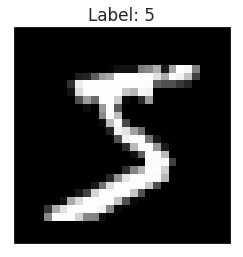

In [30]:
plt.plot(5,5,1)
plt.imshow(X_train[0], cmap='gray')
plt.title("Label: " + str(y_train[0]))
plt.xticks([])
plt.yticks([])


#### Statisics

 - How many examples do I have in my dataset?
 - What is the shape of my input images?
 - How many classes do I have?
 - What is the class distribution in my dataset?
 - Is the testing set similar to the training set?


Number of training examples:  60000
Number of testing examples:  10000
Shape of input images:  (28, 28)
Data type:  uint8
Number of classes:  10
Counter({1: 6742, 7: 6265, 3: 6131, 2: 5958, 9: 5949, 0: 5923, 6: 5918, 8: 5851, 4: 5842, 5: 5421})


<BarContainer object of 10 artists>

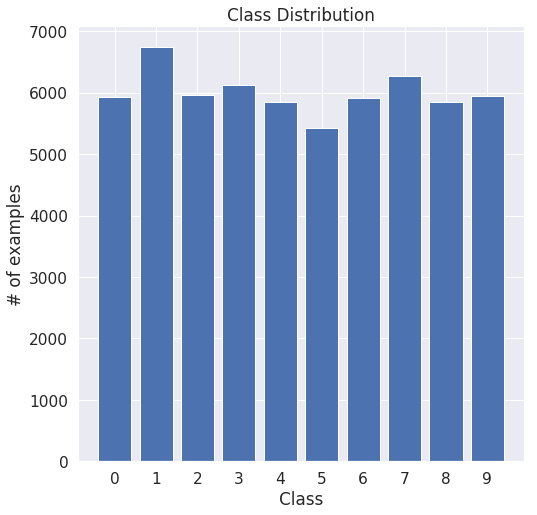

In [33]:
num_of_classes = np.unique(y_train).shape[0]
print("Number of training examples: ", X_train.shape[0])
print("Number of testing examples: ", X_test.shape[0])
print("Shape of input images: ", X_train.shape[1:])
print("Data type: ", X_train.dtype)
print("Number of classes: ", num_of_classes)

print(Counter(y_train))

#counts each instance of every class and puts in dict
class_distrib = Counter(y_train)
x=range(10)
y = [class_distrib[cls] for cls in x]
plt.figure(figsize=(8,8))
plt.xticks(x)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("# of examples")
plt.bar(x,y)

### Pixel wise standardization

In [10]:
pixel_mean = X_train.mean(axis=0)
pixel_std = X_train.std(axis=0) + 1e-10 #prevents division by zero-error
# piwel-wise normalization on the train and test set
X_train = (X_train - pixel_mean) / pixel_std
X_test = (X_test - pixel_mean) / pixel_std


#### Visualizing the pixel-mean and the pixel-std images

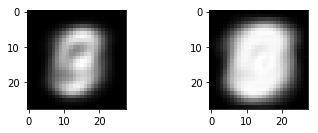

In [11]:
plt.subplot(2,2,1)
plt.imshow(pixel_mean, cmap='gray')
plt.subplot(2,2,2)
plt.imshow(pixel_std, cmap='gray')

#### Visualizing the normalized data

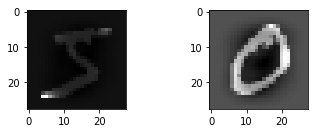

In [12]:
plt.subplot(2,2,1)
plt.imshow(X_train[0], cmap='gray')
plt.subplot(2,2,2)
plt.imshow(X_train[1], cmap='gray')

#### Transform label to a binary class matrix

In [13]:
print("Label: ", y_train[0])
y_train = to_categorical(y_train, num_of_classes)
y_test = to_categorical(y_test, num_of_classes)
print("is now")
print(y_train[0])

Label:  5
is now
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


### Change data shape

Tensorflow expects image to be of shape (height, width, channel), but as shown earlier the image is of shape (28,28). Since our images are grayscale we add one channel to our image shape and set this to 1.

In [14]:
print("Old shapes: ", X_train.shape, X_test.shape)
X_train = X_train.reshape((60000, 28, 28, 1)).astype(np.float32)
X_test = X_test.reshape((10000, 28, 28, 1)).astype(np.float32)
print("New shapes: ", X_train.shape, X_test.shape)

Old shapes:  (60000, 28, 28) (10000, 28, 28)
New shapes:  (60000, 28, 28, 1) (10000, 28, 28, 1)


#### Split data into training and validation sets

Validation set to validate our model, and keep test set seperate from this. We use the validation set for fine-tuning different hyperparameters in our model during training. Here I have used train_test_split from sci-kit learn for this.

In [15]:
#fixed random seed for reproducibility
seed = 7
np.random.seed(seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=seed)

print("Training set shape: ", X_train.shape)
print("Validation set shape: ", X_val.shape)
print("Testing set shape: ", X_test.shape)

Training set shape:  (48000, 28, 28, 1)
Validation set shape:  (12000, 28, 28, 1)
Testing set shape:  (10000, 28, 28, 1)


#### Data augmentation

Performs data augmentation using Keras built-in API and plots a batch of the images. Found that this does not give high accuracy and loss was hovering around 0.4-0.5, and test accuracy was 91.8%. Decided to not perform data augmentation on final model.

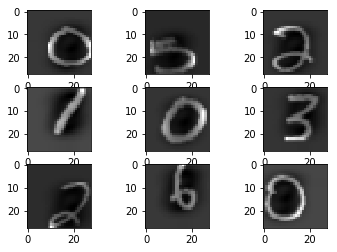

In [16]:
datagen = ImageDataGenerator(width_shift_range=0.2,
                            height_shift_range=0.2)

datagen.fit(X_train)
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].reshape(28, 28), cmap='gray')
    plt.show()
    break

### Build Model

In [17]:
def build_model(input_shape):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(10, activation="softmax"))
    return model

model = build_model((28,28,1))

### Compile Model and model summary

In [18]:
model.compile(optimizer=keras.optimizers.Adam(lr=0.001, epsilon=1e-7),
             loss="categorical_crossentropy",
             metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [19]:
#model.fit_generator(datagen.flow(X_train, y_train, batch_size=128),
#                   steps_per_epoch=len(X_train)/128, epochs = 10,
#                    verbose=2,
#                   validation_data=(X_val, y_val)
#                    )

model.fit(X_train, y_train,
         batch_size=128,
         epochs=10,
         verbose=2,
         validation_data=(X_val, y_val))

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
 - 1s - loss: 0.3125 - acc: 0.9097 - val_loss: 0.1826 - val_acc: 0.9498
Epoch 2/10
 - 1s - loss: 0.1278 - acc: 0.9625 - val_loss: 0.1525 - val_acc: 0.9592
Epoch 3/10
 - 1s - loss: 0.0850 - acc: 0.9760 - val_loss: 0.1314 - val_acc: 0.9640
Epoch 4/10
 - 2s - loss: 0.0600 - acc: 0.9829 - val_loss: 0.1260 - val_acc: 0.9658
Epoch 5/10
 - 2s - loss: 0.0448 - acc: 0.9883 - val_loss: 0.1207 - val_acc: 0.9691
Epoch 6/10
 - 1s - loss: 0.0343 - acc: 0.9911 - val_loss: 0.1196 - val_acc: 0.9694
Epoch 7/10
 - 2s - loss: 0.0259 - acc: 0.9938 - val_loss: 0.1221 - val_acc: 0.9690
Epoch 8/10
 - 3s - loss: 0.0209 - acc: 0.9957 - val_loss: 0.1259 - val_acc: 0.9691
Epoch 9/10
 - 1s - loss: 0.0187 - acc: 0.9965 - val_loss: 0.1259 - val_acc: 0.9692
Epoch 10/10
 - 1s - loss: 0.0163 - acc: 0.9967 - val_loss: 0.1284 - val_acc: 0.9717


### Visualize and analyse

Fit tracks both loss and accuracy on training and validation set

#### Loss

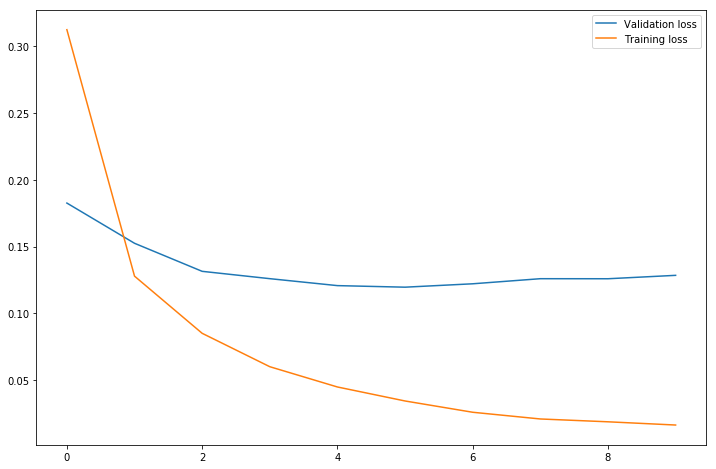

In [20]:
history = model.history.history

plt.figure(figsize=(12, 8))
plt.plot(history["val_loss"], label="Validation loss")
plt.plot(history["loss"], label="Training loss")
plt.legend()

#### Accuracy

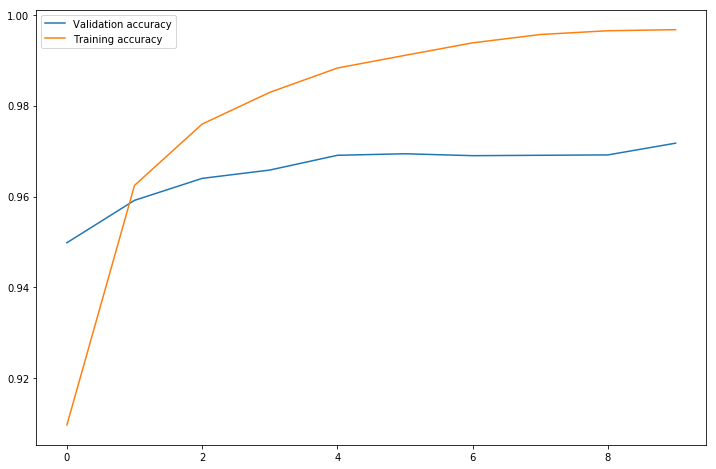

In [21]:
plt.figure(figsize=(12, 8))
plt.plot(history["val_acc"], label="Validation accuracy")
plt.plot(history["acc"], label="Training accuracy")
plt.legend()

## Evaluation on test set

In [22]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test loss: ", test_loss)
print("Test acc: ", test_acc)

10000/10000 [==============================] - 0s 27us/step
Test loss:  0.12363934330259509
Test acc:  0.9718


#### Compare loss to previous plot

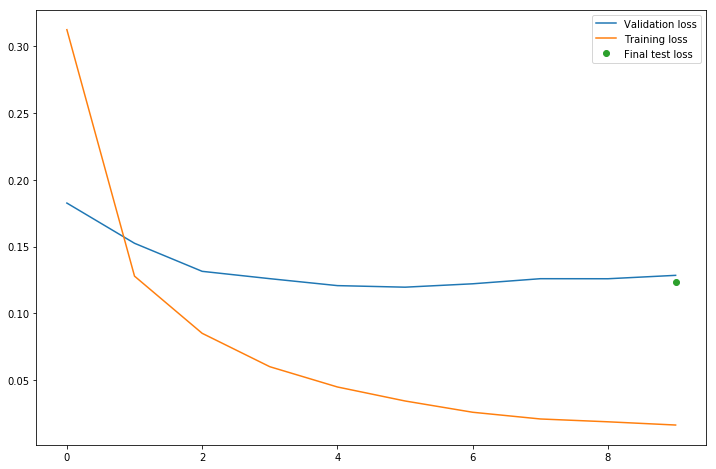

In [23]:
history = model.history.history
plt.figure(figsize=(12, 8))
plt.plot(history["val_loss"], label="Validation loss")
plt.plot(history["loss"], label="Training loss")
plt.plot([9], [test_loss], 'o', label="Final test loss")
plt.legend()

In [25]:
predicted = model.predict(X_test)
target_names = ["0","1", "2", "3", "4", "5", "6", "7", "8", "9"]

target_names = ["airplane","automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
report = classification_report(y_test.argmax(axis=1), predicted.argmax(axis=1), target_names=target_names)
print(report)


             precision    recall  f1-score   support

   airplane       0.98      0.99      0.99       980
 automobile       0.99      0.99      0.99      1135
       bird       0.96      0.97      0.97      1032
        cat       0.96      0.98      0.97      1010
       deer       0.97      0.97      0.97       982
        dog       0.98      0.96      0.97       892
       frog       0.98      0.98      0.98       958
      horse       0.97      0.97      0.97      1028
       ship       0.96      0.95      0.96       974
      truck       0.97      0.95      0.96      1009

avg / total       0.97      0.97      0.97     10000



In [26]:
model.save('my_model.h5')
del model